# Production Returning for 2024-25 Season
- Book will calculate how much of each teams statistical production (goals, assists, pen, +/-) was lost in the offseason and how much is returning

In [1]:
# Dependencies

import os
import sys
import pandas as pd
import numpy as np


# path to TEMP folder
temp_folder = os.path.join(os.getcwd(), '..', 'TEMP')
# Data folder
data_folder = os.path.join(os.getcwd(), '..', 'data')
# Image folder
img_folder = os.path.join(os.getcwd(), '..', 'images')
# Logo folder
logo_folder = os.path.join(os.getcwd(), '..', 'images', 'logos')

## Path to 2023-24 stats (csv)
stats_file = os.path.join(data_folder, 'player_stats_2023_v1.csv')
stats_2023_df = pd.read_csv(stats_file)


################################################################################
roster_file = os.path.join(data_folder, 'roster_2024_current_v3.csv') # PATH TO THE ROSTER FILE
roster_2024_df = pd.read_csv(roster_file) # read as dataframe

# Path to school info table (csv)
school_info_file = os.path.join(data_folder, 'arena_school_info.csv')
school_info_df = pd.read_csv(school_info_file)

In [2]:
roster_2024_df.head(35)

# Print roster length
print(f"Roster length: {len(roster_2024_df)}")

### HOTFIX - REMOVE GOALIES
roster_2024_df = roster_2024_df[roster_2024_df['Position'] != 'Goaltenders']

# Print updated roster length
print(f"Updated roster length: {len(roster_2024_df)}")


Roster length: 1820
Updated roster length: 1619


## Dictionaries and Constants

In [3]:
## Conference Membership

atlantic = ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
            'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart', 'St Lawrence']

big_ten = ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin']

ccha = ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
        'Minnesota State', 'Northern Michigan', 'St Thomas']

ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']

hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']

nchc = ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 'St Cloud State',
        'Western Michigan']

independents = ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']

# Create a dictionary of {Team: logo_abv} for each team with .png added to the end
logo_mapping = {}

for index, row in school_info_df.iterrows():
    logo_mapping[row['Team']] = row['logo_abv'] + '.png'

# print(logo_mapping)

#### Style and Colors

In [4]:
color_scheme = {
    'Returning Goals': '#2E8B57',  # Dark Green
    'Returning Assists': '#90EE90',  # Light Green
    'Departed Goals': '#B22222',  # Dark Red
    'Departed Assists': '#FF7F7F',  # Light Red
    'New Goals': '#1E90FF',  # Dark Blue
    'New Assists': '#87CEFA'  # Light Blue
}


### Data Modifications
- Remove Trouble character from Team Names



##### Stats Table (2023 stats)

In [5]:


######
# Remove - from CHN Team names
stats_2023_df['Team'] = stats_2023_df['Team'].str.replace('-', ' ')
# roster_2024_df['Team'] = roster_2024_df['Team'].str.replace('-', ' ')
stats_2023_df['Team'] = stats_2023_df['Team'].str.replace('.', '')
stats_2023_df['Team'] = stats_2023_df['Team'].str.replace("'", '')
# Lower Case columns
stats_2023_df.columns = stats_2023_df.columns.str.lower()

stats_2023_df.head()

,clean_player,team,g,a,pts,plus_minus,sh,pim,games_played
0,A.J. Hodges,Bentley,6,9,15,-1,57,2,29
1,A.J. Macaulay,Alaska,5,10,15,9,44,14,34
2,AJ Casperson,Long Island,0,1,1,1,7,2,12
3,Aaron Bohlinger,Massachusetts,3,5,8,1,22,4,34
4,Aaron Grounds,Long Island,1,2,3,-5,14,16,11


##### 2024 Roster

In [6]:


# Rename Current Team to Team
roster_2024_df = roster_2024_df.rename(columns={'Current Team': 'Team'})

# Create ne column called CLean_Player by merging First and Last Name
roster_2024_df['Clean_Player'] = roster_2024_df['First_Name'] + ' ' + roster_2024_df['Last_Name']
# Strip leading and trailing spaces
roster_2024_df['Clean_Player'] = roster_2024_df['Clean_Player'].str.strip()

# Lower Case columns
roster_2024_df.columns = roster_2024_df.columns.str.lower()

## HOTFIX TO ADD RHETT PITLICK TO ROSTER - MINN to MINN STATE TRANSFER
##

# (Minnesota State, Pitlick, Rhett, 0, Forward, Sr, 5-10, 165, 2/7/2001, Chaska, Minn., 70, 2019, 5, Minnesota, B1G, Chaska, Minnesota, USA, Rhett Pitlick, 5-10, 165, Forward, 2/7/2001, 70, 2019, 5, Minnesota, B1G, Chaska, Minnesota, USA)

# Add Rhett Pitlick to the roster
roster_2024_df = roster_2024_df._append({'team': 'Minnesota State', 
    'last_name': 'Pitlick', 'first_name': 'Rhett', 'class': 'Sr', 
    'position': 'Forward', 'height': '5-10', 'weight': 165, 
    'dob': '2/7/2001', 'hometown': 'Chaska, Minn.', 'number': 70, 
    'year': 2019, 'draft_round': 5, 'draft_team': 'Minnesota', 
    'conference': 'B1G', 'hometown_state': 'Chaska, Minnesota, USA', 
    'clean_player': 'Rhett Pitlick'}, ignore_index=True)


roster_2024_df.head()
# EXPORT ROSTER FILE TO TEMP FOLDER
# roster_2024_df.to_csv(os.path.join(temp_folder, 'roster_2024_transformed.csv'), index=False)


,team,last_name,first_name,no,position,yr,ht,wt,dob,hometown,...,clean_player,class,height,weight,number,year,draft_round,draft_team,conference,hometown_state
0,Lake Superior,Barone,Adam,6.0,Defensemen,Fr,1-Jun,174.0,5/6/2004,"Sault Ste. Marie, Ont.",...,Adam Barone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Lake Superior,Blanchett,Jack,16.0,Defensemen,So,11-May,185.0,5/12/2003,"Monroe, Mich.",...,Jack Blanchett,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Lake Superior,Brown,Mike,3.0,Defensemen,Jr,2-Jun,209.0,4/3/2001,"Belmont, Mass.",...,Mike Brown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Lake Superior,Bushy,Evan,5.0,Defensemen,So,1-Jun,195.0,3/26/2002,"Mankato, Minn.",...,Evan Bushy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Lake Superior,Conrad,Jacob,4.0,Defensemen,Fr,11-May,180.0,5/18/2002,"Green Bay, Wis.",...,Jacob Conrad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Indentify Transfers

### CHN Data
- Compare 2024 roster to 2023 year end stats and flag players as returning vs departed
- Output 'transfers' dataframe with player, team 2023 and team 2024

In [7]:
# Step 1: Identify players that appear on different teams in the 2023 stats compared to the 2024 roster

# Merge the dataframes on the player name ('Clean_Player') to compare teams
transfer_df = pd.merge(stats_2023_df[['clean_player', 'team']], roster_2024_df[['clean_player', 'team']], on='clean_player', suffixes=('_2023', '_2024'))

# Filter for players who have a different team in 2023 compared to 2024
transfers = transfer_df[transfer_df['team_2023'] != transfer_df['team_2024']]
# # Rename Clean_Player to Player
transfers = transfers.rename(columns={'clean_player': 'player'})


# Reindex and save as csv to TEMP folder
transfers = transfers.reset_index(drop=True)
transfers.to_csv(os.path.join(temp_folder, 'transfers_2024.csv'))

# Create a count of transfers in per team
transfer_counts = transfers['team_2023'].value_counts().reset_index()
transfer_counts.columns = ['team', 'transfer_count']

## Print report on transfers


# transfers.head()
transfer_counts.head(10)


,team,transfer_count
0,Northern Michigan,11
1,Colorado College,8
2,Alaska,7
3,Arizona State,5
4,Mass Lowell,5
5,Colgate,5
6,Holy Cross,5
7,Lake Superior,5
8,Miami,5
9,Wisconsin,5


#### Merge CHN derived transfer list with 2023 stats

In [8]:
stats_2023_df.head(10)
# rename clean_player to player
stats_2023_df = stats_2023_df.rename(columns={'clean_player': 'player'})

In [9]:
### Get 2023 stats for players who transferred
### Merge the transfers with the 2023 stats to get their stats
transfers_stats = pd.merge(transfers, stats_2023_df, on='player')



transfers_stats.to_csv(os.path.join(temp_folder, 'transfers_stats_2024.csv'), index=False)

## Other Transfer Data - The Rink Live
- Taken from the Rink Live Transfer Tracker, seemingly the best source available online

In [10]:
### Open the data from The Rink Live
rink_live_path = os.path.join(data_folder, 'rink_live_2024_transfer_table.csv')
rink_live_df = pd.read_csv(rink_live_path)

# Extract Detination Team, Player and stats (GP, G, A, P, POS. Yr.) to new table to compare with my transfer table
rink_live_df = rink_live_df[['PLAYER', 'DESTINATION TEAM', 'POS.', 'YR.', 'GP', 'G', 'A', 'P', '2023/24 TEAM', 'NOTABLE INFO']]

# Remove . from column names
rink_live_df.columns = [col.replace('.', '') for col in rink_live_df.columns]
# Camel Case the column names
rink_live_df.columns = [col.replace(' ', '_').lower() for col in rink_live_df.columns]


# Rename columns to match my transfer table
rink_live_df = rink_live_df.rename(columns={
    'destination_team': 'team_2024',
    
    '2023/24_team': 'team_2023',
    
})

# Clean up player names in rink_live_df
rink_live_df['player'] = rink_live_df['player'].str.replace('-', ' ')
rink_live_df['player'] = rink_live_df['player'].str.replace('.', '')
rink_live_df['player'] = rink_live_df['player'].str.replace("'", '')
rink_live_df['player'] = rink_live_df['player'].str.strip()

rink_live_df.head()


,player,team_2024,pos,yr,gp,g,a,p,team_2023,notable_info
0,Cole Hanson,(DI golf at Mercer),F,Jr.,34,4,4,8,Maine,Transferring to Mercer to pursue DI golf.
1,Austin McCarthy,Adrian,F,Sr.,20,3,2,5,Ferris State,NaN
2,Brett Bamber,AIC,D,So.,34,4,9,13,Alaska-Anchorage,NaN
3,Danny Weight,AIC,F,Sr.,6,1,0,1,Colorado College,Two-time transfer. Also played at BC.
4,Noah Serdachny,AIC,F,So.,5,0,0,0,Colorado College,NaN


In [11]:
### HOTFIXES FOR THE RINK LIVE DATA

# AIC = American Intl
# UMass Lowell = Mass Lowell
# Remove - in team names
rink_live_df['team_2024'] = rink_live_df['team_2024'].str.replace('-', ' ')

# Create a mapping for the teams
team_mapping = {
    'AIC': 'American Intl',
    'UMass Lowell': 'Mass Lowell',
}


#### Merge Rink Live data into existing 'transfers' df

In [12]:
# Merge my transfer table with The Rink Live data
merged_df = transfers.merge(rink_live_df, on=['player', 'team_2024'], how='outer', indicator=True)

# Identify players that are in my transfer table but not in The Rink Live data
only_in_my_transfers = merged_df[merged_df['_merge'] == 'left_only']

# Identify players that are in The Rink Live data but not in my transfer table
only_in_rink_live = merged_df[merged_df['_merge'] == 'right_only']

# Save the results to CSV files
only_in_my_transfers.to_csv(os.path.join(temp_folder, 'only_in_my_transfers.csv'), index=False)
only_in_rink_live.to_csv(os.path.join(temp_folder, 'only_in_rink_live.csv'), index=False)

# Print a summary of the results
print(f"Total transfers in my data: {len(transfers)}")
print(f"Total transfers in The Rink Live data: {len(rink_live_df)}")
print(f"Players only in my transfers data: {len(only_in_my_transfers)}")
print(f"Players only in The Rink Live data: {len(only_in_rink_live)}")


Total transfers in my data: 169
Total transfers in The Rink Live data: 350
Players only in my transfers data: 49
Players only in The Rink Live data: 231


In [13]:
# Step 2: Quantify how much production is transferring into each team
## Rename clean_player to player in stats_2023_df for merging
stats_2023_df = stats_2023_df.rename(columns={'clean_player': 'player'})

# Merge the transfer list with the stats_2023_df to bring in the player stats
transfer_stats = transfers.merge(stats_2023_df, on='player', how='left')





transfer_stats.head()

# See Northeastern team_2024
northeastern_transfers = transfer_stats[transfer_stats['team_2024'] == 'Northeastern']
northeastern_transfers.head()

# # Michigan State team_2024
# michigan_state_transfers = transfer_stats[transfer_stats['team_2024'] == 'Michigan State']
# michigan_state_transfers.head()

# # Michigan team_2024
# michigan_transfers = transfer_stats[transfer_stats['team_2024'] == 'Michigan']
# michigan_transfers.head()

,player,team_2023,team_2024,team,g,a,pts,plus_minus,sh,pim,games_played
50,Cristophe Tellier,Quinnipiac,Northeastern,Quinnipiac,7,19,26,11,70,12,39
80,Jack Williams,Notre Dame,Northeastern,Northeastern,17,19,36,0,86,8,34
81,Jack Williams,Notre Dame,Northeastern,Notre Dame,0,0,0,0,0,0,1
84,Jake Boltmann,Notre Dame,Northeastern,Notre Dame,0,2,2,-2,32,22,30
85,Jake Higgins,Holy Cross,Northeastern,Holy Cross,5,4,9,2,53,17,31


In [14]:
# roster_2024_df.head()


In [15]:
# Rename clean_player to player in roster_2024_df for mergingroster_2024_df
roster_2024_df = roster_2024_df.rename(columns={'clean_player': 'player'})

# Step 1: Match the players from 2023 stats to 2024 roster based on 'Clean_Player'
# We'll merge the two DataFrames on 'Clean_Player' to identify returning players
merged_df = pd.merge(stats_2023_df, roster_2024_df[['player', 'team']], on='player', how='left', suffixes=('_2023', '_2024'))

# Step 2: Classify players as "Returning" or "Departed"
merged_df['Status'] = merged_df['team_2024'].notna().map({True: 'Returning', False: 'Departed'})

# HOTFIX TO DEAL WITH TRANSFERRED PLAYERS
# If Team_2023 is not equal to Team_2024, then the player transferred - set Status to 'Departed'
merged_df.loc[merged_df['team_2023'] != merged_df['team_2024'], 'Status'] = 'Departed'

# Step 3: Calculate total production for each group (Returning and Departed) by team
team_production = merged_df.groupby(['team_2023', 'Status']).agg({
    'g': 'sum',
    'a': 'sum',
    'sh': 'sum',
    'pim': 'sum',
    'pts': 'sum',
    'games_played': 'sum'
}).reset_index()

# Step 4: Pivot the table to make "Returning" and "Departed" production easy to compare for each team
team_production_pivot = team_production.pivot(index='team_2023', columns='Status', values=['g', 'a', 'pts', 'sh', 'pim', 'games_played']).fillna(0)

# Flatten the MultiIndex for clarity
team_production_pivot.columns = ['_'.join(col).strip() for col in team_production_pivot.columns.values]

# Copy team_2023 values to new column called Team
team_production_pivot['Team'] = team_production_pivot.index



team_production_pivot.head()

,g_Departed,g_Returning,a_Departed,a_Returning,pts_Departed,pts_Returning,sh_Departed,sh_Returning,pim_Departed,pim_Returning,games_played_Departed,games_played_Returning,Team
team_2023,,,,,,,,,,,,,
Air Force,51,64,83,104,134,168,511,665,220,206,340,418,Air Force
Alaska,76,34,129,66,205,100,674,351,345,177,428,250,Alaska
Alaska Anchorage,44,51,84,72,128,123,541,451,246,191,359,323,Alaska Anchorage
American Intl,52,67,101,92,153,159,606,580,238,196,454,347,American Intl
Arizona State,70,59,92,129,162,188,553,578,213,366,353,409,Arizona State


###### OUTPUT BLOCK 

In [16]:

# incoming_transfer_stats.head()

In [17]:
## Merge in the transfer stats to quantify incoming production

# Step 1: Calculate total production for incoming transfers
incoming_transfer_stats = transfer_stats.groupby('team_2024').agg({
    'g': 'sum',
    'a': 'sum',
    'sh': 'sum',
    'pim': 'sum',
    'pts': 'sum',
    'games_played': 'sum'
}).reset_index()

# Step 2: Rename the columns for clarity
incoming_transfer_stats = incoming_transfer_stats.rename(columns={
    'team_2024': 'Team',
    'g': 'incoming_g',
    'a': 'incoming_a',
    'sh': 'incoming_sh',
    'pim': 'incoming_pim',
    'pts': 'incoming_pts',
    'games_played': 'incoming_games_played'
})

# Step 3: Merge the incoming transfer stats with the team production pivot
final_team_production = team_production_pivot.merge(incoming_transfer_stats, on='Team', how='left').fillna(0)

# # Step 4: Calculate total production for each team
# final_team_production['total_g'] = final_team_production['incoming_g'] + final_team_production['g_Returning']

# # Output to TEMP folder
final_team_production.to_csv(os.path.join(temp_folder, 'final_team_production_2024_v1.01.csv'), index=False)



In [18]:
final_team_production.head(10)

# Check Northern Michigan
final_team_production[final_team_production['Team'] == 'Northern Michigan']
final_team_production[final_team_production['Team'] == 'Harvard']

,g_Departed,g_Returning,a_Departed,a_Returning,pts_Departed,pts_Returning,sh_Departed,sh_Returning,pim_Departed,pim_Returning,games_played_Departed,games_played_Returning,Team,incoming_g,incoming_a,incoming_sh,incoming_pim,incoming_pts,incoming_games_played
22,1,69,3,110,4,179,14,756,6,218,62,562,Harvard,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
final_team_production.head(10)

,g_Departed,g_Returning,a_Departed,a_Returning,pts_Departed,pts_Returning,sh_Departed,sh_Returning,pim_Departed,pim_Returning,games_played_Departed,games_played_Returning,Team,incoming_g,incoming_a,incoming_sh,incoming_pim,incoming_pts,incoming_games_played
0,51,64,83,104,134,168,511,665,220,206,340,418,Air Force,0.0,0.0,0.0,0.0,0.0,0.0
1,76,34,129,66,205,100,674,351,345,177,428,250,Alaska,10.0,30.0,150.0,62.0,40.0,184.0
2,44,51,84,72,128,123,541,451,246,191,359,323,Alaska Anchorage,2.0,5.0,53.0,12.0,7.0,54.0
3,52,67,101,92,153,159,606,580,238,196,454,347,American Intl,9.0,20.0,155.0,53.0,29.0,117.0
4,70,59,92,129,162,188,553,578,213,366,353,409,Arizona State,47.0,62.0,461.0,65.0,109.0,163.0
5,28,65,56,107,84,172,267,734,109,236,212,493,Army,0.0,0.0,0.0,0.0,0.0,0.0
6,29,59,46,102,75,161,254,648,91,187,228,449,Augustana,9.0,21.0,99.0,18.0,30.0,58.0
7,46,71,79,124,125,195,418,713,76,171,259,502,Bemidji State,18.0,32.0,144.0,63.0,50.0,88.0
8,14,81,20,150,34,231,174,892,71,300,154,544,Bentley,0.0,0.0,0.0,0.0,0.0,0.0
9,85,98,120,203,205,301,555,753,101,280,317,498,Boston College,2.0,6.0,36.0,16.0,8.0,27.0


# PLOTTING SECTION

## Basic All Team

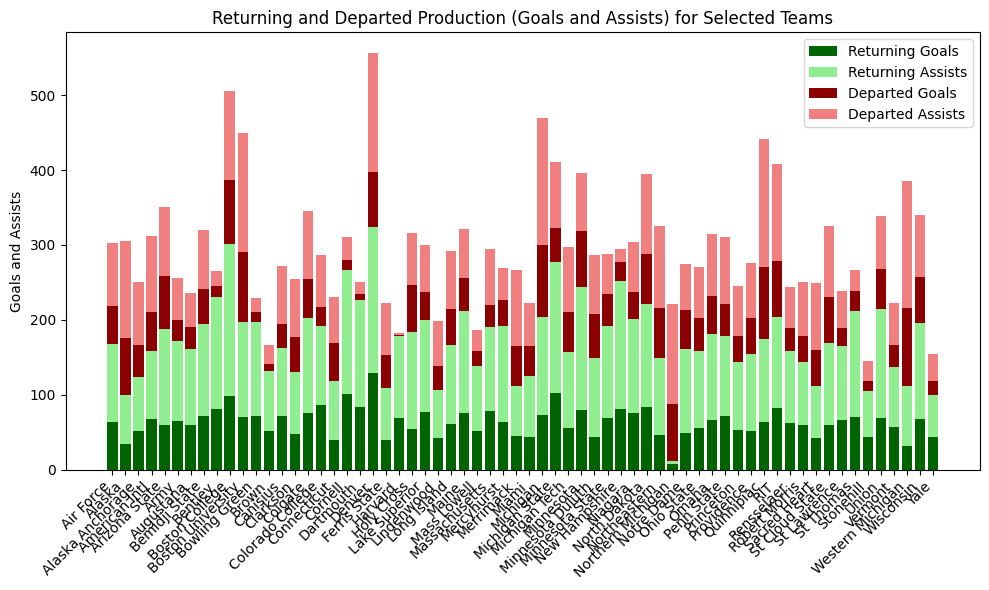

In [20]:
# # Load the uploaded CSV file
# production_data_path = '/mnt/data/team_production_2024_v1.csv'

# # Read the file into a DataFrame
# production_df = pd.read_csv(production_data_path)

import matplotlib.pyplot as plt

production_df = team_production_pivot.copy()
# Select 10 random teams for testing
random_teams_df = production_df

# Prepare the data for plotting
teams = random_teams_df['Team']
returning_goals = random_teams_df['g_Returning']
returning_assists = random_teams_df['a_Returning']
departed_goals = random_teams_df['g_Departed']
departed_assists = random_teams_df['a_Departed']

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars
ax.bar(teams, returning_goals, color='darkgreen', label='Returning Goals')
ax.bar(teams, returning_assists, bottom=returning_goals, color='lightgreen', label='Returning Assists')
ax.bar(teams, departed_goals, bottom=returning_goals + returning_assists, color='darkred', label='Departed Goals')
ax.bar(teams, departed_assists, bottom=returning_goals + returning_assists + departed_goals, color='lightcoral', label='Departed Assists')

# Add labels and title
ax.set_ylabel('Goals and Assists')
ax.set_title('Returning and Departed Production (Goals and Assists) for Selected Teams')
ax.legend()

# Rotate the team names for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


## Dictionary Of Conferences and Ranks


In [21]:
# Conference Dictionary with Logo Mapping

## Conference Membership

atlantic = ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
            'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart', 'St Lawrence']

big_ten = ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin']

ccha = ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
        'Minnesota State', 'Northern Michigan', 'St Thomas']

ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']

hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']

nchc = ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 'St Cloud State',
        'Western Michigan']

independents = ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']

# Create a dictionary of {Team: logo_abv} for each team with .png added to the end
logo_mapping = {}

for index, row in school_info_df.iterrows():
    logo_mapping[row['Team']] = row['logo_abv'] + '.png'

# print(logo_mapping)


# OUTPUT

In [22]:
final_team_production.tail(10)

# Reorder columns and put Team up front, leaving the rest in order
final_team_production = final_team_production[['Team', 'g_Returning', 'a_Returning', 'g_Departed', 'a_Departed', 
                                               'incoming_g', 'incoming_a', 'incoming_pts', 'incoming_sh', 
                                               'incoming_pim', 'incoming_games_played']]






# Sort by incoming transfer goals
# final_team_production = final_team_production.sort_values(by='incoming_g', ascending=False)
# OUTPUT TO TEMP FOLDER
final_team_production.to_csv(os.path.join(temp_folder, 'final_team_production_sorted_v1.04.csv'), index=False)
# final_team_production.head(10)